In [88]:
import os

import pandas as pd
import pandas_datareader as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

import seaborn as sns
import itertools

import FinanceDataReader as fdr
from IPython.display import Image
import warnings 
warnings.filterwarnings('ignore')

# 분석할 데이터: 시티랩스 종가

In [61]:
df = fdr.DataReader('139050','2016')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,3050,3135,3010,3020,1283754,0.006667
2016-01-05,2960,3030,2930,3020,725642,0.000000
2016-01-06,3000,3065,2840,2895,954645,-0.041391
2016-01-07,2865,3100,2840,2945,1726234,0.017271
2016-01-08,2900,2940,2755,2920,821785,-0.008489


In [62]:
data = df['Close'].to_frame()
data

,Close
Date,
2016-01-04,3020
2016-01-05,3020
2016-01-06,2895
2016-01-07,2945
2016-01-08,2920
...,...
2022-06-08,795
2022-06-09,795
2022-06-10,759


# Box-Jenkins ARIMA Procedure
* (1) Data preprocessing
* (2) Identify Model to be Tentatively Entertained
* (3) Estimate Parameters
* (4) Diagnosis check
* (5) 모델을 통한 예측

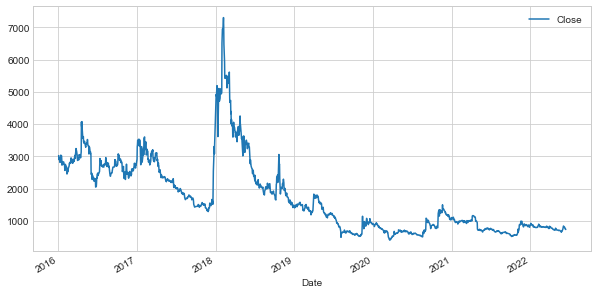

In [63]:
fig = data.plot(figsize=(10,5))

## (1)Data preprocessing

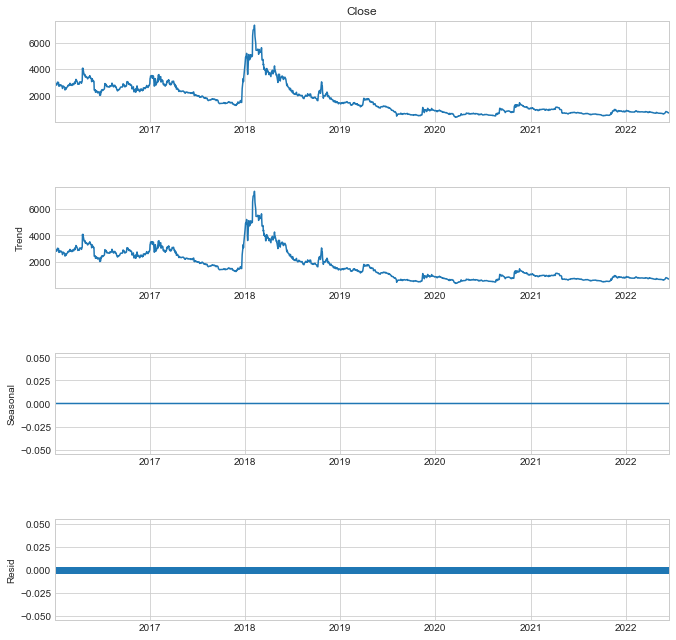

In [64]:
# Seasonal decomposition plot: moving average를 사용하여 Seasonal decomposition
#1. 원문 데이터
#2. Trend: 예측된 trend 요소
#3. Seasonal: 예측된 Seasonal 요소
#4. resid: 예측된 residual

decomposition =sm.tsa.seasonal_decompose(data['Close'], model= 'additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

## (2) Identify Model to be Tentatively Entertainted

In [65]:
# ACF:
# PACF:

In [66]:
# Train:test = 8:2
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

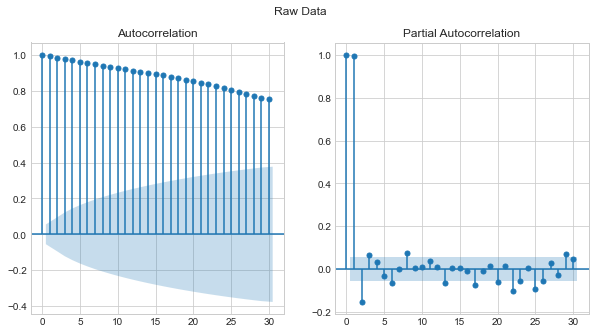

In [67]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),lags=30, ax=ax[1]);

## (3) Differencing 

* Differncing(차분): 데이터가 시계열이 아닐때(non-stationary), 시계열 데이터 모델을 사용하기 위해 
현 시점 데이터에서 d 시점 이전 데이터를 뺀 것

* 1차 차분: Yt = Xt- Xt-1
* 2차 차분: Yt = Xt- Xt-2
...
* d차 차분:  Yt = Xt- Xt-d

In [68]:
dif_train_data = train_data.copy()
dif_train_data = dif_train_data['Close'].diff()
dif_train_data.dropna(inplace=True)

In [69]:
print(train_data)
print(dif_train_data)

            Close
Date             
2016-01-04   3020
2016-01-05   3020
2016-01-06   2895
2016-01-07   2945
2016-01-08   2920
...           ...
2021-02-24    950
2021-02-25    995
2021-02-26    945
2021-03-02   1000
2021-03-03    990

[1267 rows x 1 columns]
Date
2016-01-05      0.0
2016-01-06   -125.0
2016-01-07     50.0
2016-01-08    -25.0
2016-01-11   -110.0
              ...  
2021-02-24    -30.0
2021-02-25     45.0
2021-02-26    -50.0
2021-03-02     55.0
2021-03-03    -10.0
Name: Close, Length: 1266, dtype: float64


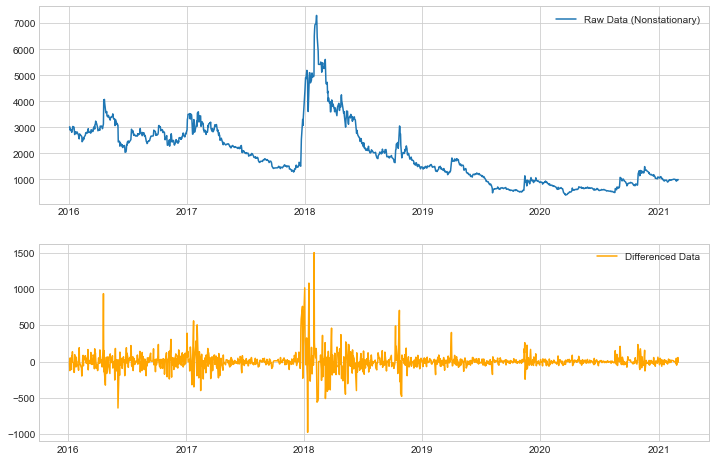

In [70]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(train_data['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(2,1,2)
plt.plot(dif_train_data,'orange')
plt.legend(['Differenced Data']) # 1차 차분을 해도 시계열 모양을 띄지 않음
plt.show()

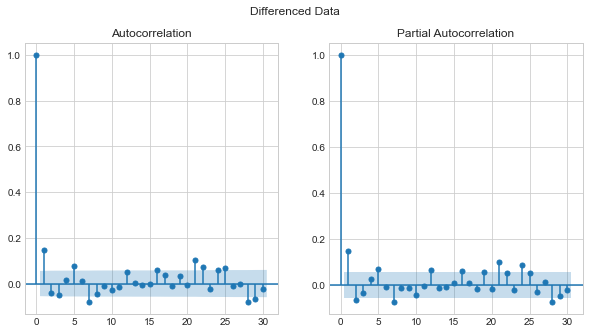

In [72]:
fig, ax =plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(dif_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(dif_train_data.values.squeeze(),lags=30, ax=ax[1]);

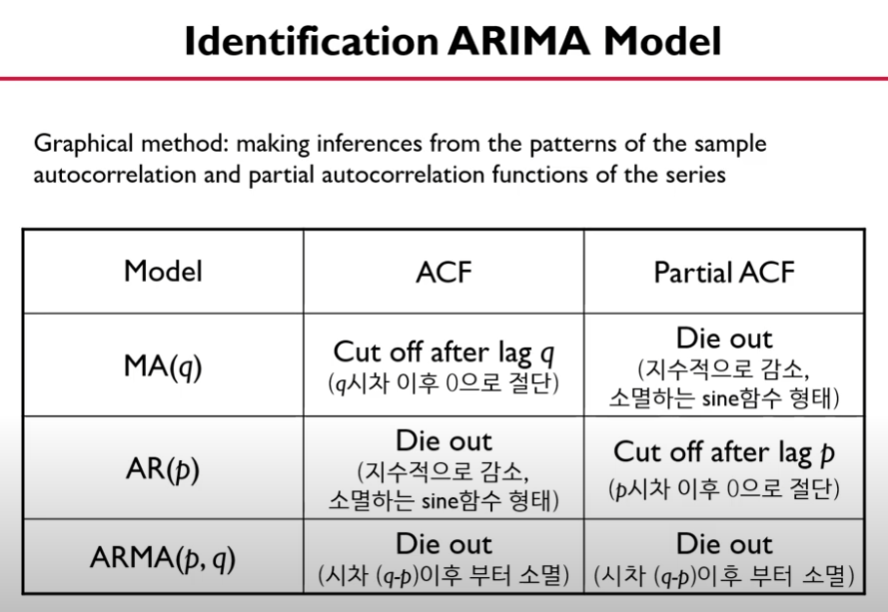

In [75]:
Image('./ARIMA_model_표.png')

## (4) Diagnose Check -ARIMA

### 주관적으로 판단해보기

In [81]:
model = ARIMA(train_data.values, order=(1,1,0)) # 판단근거: 
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1266
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7911.020
Method:                       css-mle   S.D. of innovations            125.196
Date:                Wed, 15 Jun 2022   AIC                          15828.040
Time:                        00:47:28   BIC                          15843.471
Sample:                             1   HQIC                         15833.838
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6035      4.116     -0.390      0.697      -9.670       6.463
ar.L1.D.y      0.1452      0.028      5.224      0.000       0.091       0.200
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.8874           +0.0000j            6.8874            0.0000
-----------------------------------------------------------------------------
"""

### 모든 경우 테스트

In [82]:
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic=[]
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC : 15853.04
ARIMA: (0, 1, 1) >> AIC : 15825.26
ARIMA: (0, 1, 2) >> AIC : 15826.27
ARIMA: (1, 1, 0) >> AIC : 15828.04
ARIMA: (1, 1, 1) >> AIC : 15826.66


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

### auto_arima 사용해보기

In [89]:
auto_arimal_model = auto_arima(train_data['Close'], start_p=1, start_q=1,max_p=3,max_q=3,
                               seasonal=False, d=1, trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15853.035, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15825.253, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15826.241, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15825.498, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15828.042, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15826.646, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15827.172, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15827.460, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15824.586, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15825.864, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15818.501, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15817.810, Time=0.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15824.946, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15826.772, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec



In [90]:
auto_arimal_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -7901.905
Date:                Wed, 15 Jun 2022   AIC                          15817.810
Time:                        01:19:34   BIC                          15853.816
Sample:                             0   HQIC                         15831.337
                               - 1267                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4905      8.081     -0.184      0.854     -17.330      14.349
ar.L1          0.0068      0.051      0.132      0.895      -0.094       0.107
ar.L2         -0.8336      0.054    -15.454      0.000      -0.939      -0.728
ma.L1          0.1477      0.055      2.679      0.007       0.040       0.256
ma.L2          0.8298      0.056     14.934      0.000       0.721       0.939
ma.L3          0.0664      0.023      2.835      0.005       0.020       0.112
sigma2      1.551e+04    219.446     70.655      0.000    1.51e+04    1.59e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             48443.66
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Use Model to Forecast - ARIMA

In [95]:
prediction = auto_arimal_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
predict_index[0]
# predicted_value = prediction[0]
# predicted_ub = prediction[2][:,0]
# predicted_lb = prediction[2][:,1]


Timestamp('2021-03-04 00:00:00')

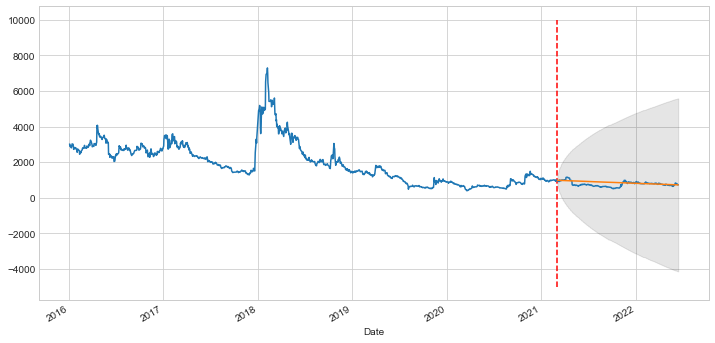

In [101]:
fig , ax = plt.subplots(figsize=(12,6))
df['Close'].plot(ax=ax)
ax.vlines('2021-03-04',-5000,10000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb,predicted_ub,color='k',alpha=0.1, label='0.95 Prediction interval')
plt.show()